<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data" data-toc-modified-id="Get-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#All-data" data-toc-modified-id="All-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>All data</a></span></li><li><span><a href="#Subset" data-toc-modified-id="Subset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Subset</a></span></li></ul></li><li><span><a href="#Classify-Largest-Image" data-toc-modified-id="Classify-Largest-Image-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classify Largest Image</a></span><ul class="toc-item"><li><span><a href="#Dataloader-and-training" data-toc-modified-id="Dataloader-and-training-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dataloader and training</a></span></li><li><span><a href="#Interpretation" data-toc-modified-id="Interpretation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Interpretation</a></span></li></ul></li><li><span><a href="#Draw-Largest-BBox" data-toc-modified-id="Draw-Largest-BBox-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Draw Largest BBox</a></span><ul class="toc-item"><li><span><a href="#via-DataBlock" data-toc-modified-id="via-DataBlock-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>via DataBlock</a></span></li><li><span><a href="#via-Transforms" data-toc-modified-id="via-Transforms-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>via Transforms</a></span><ul class="toc-item"><li><span><a href="#Showing-images-and-bboxes" data-toc-modified-id="Showing-images-and-bboxes-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Showing images and bboxes</a></span><ul class="toc-item"><li><span><a href="#Grabbing-one-im-and-bbox-for-testing" data-toc-modified-id="Grabbing-one-im-and-bbox-for-testing-3.2.1.1"><span class="toc-item-num">3.2.1.1&nbsp;&nbsp;</span>Grabbing one im and bbox for testing</a></span></li><li><span><a href="#show_im,-draw_outline,-draw_rect,-draw_text" data-toc-modified-id="show_im,-draw_outline,-draw_rect,-draw_text-3.2.1.2"><span class="toc-item-num">3.2.1.2&nbsp;&nbsp;</span><code>show_im</code>, <code>draw_outline</code>, <code>draw_rect</code>, <code>draw_text</code></a></span></li><li><span><a href="#BBox-and-ImageBBox-classes-with-show()-methods" data-toc-modified-id="BBox-and-ImageBBox-classes-with-show()-methods-3.2.1.3"><span class="toc-item-num">3.2.1.3&nbsp;&nbsp;</span><code>BBox</code> and <code>ImageBBox</code> classes with <code>show()</code> methods</a></span></li></ul></li><li><span><a href="#Building-dls-with-mid-level-api" data-toc-modified-id="Building-dls-with-mid-level-api-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Building dls with mid level api</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Model</a></span></li></ul></li></ul></li><li><span><a href="#Multi-label-Classification" data-toc-modified-id="Multi-label-Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multi-label Classification</a></span></li><li><span><a href="#Largest-BBox-and-Label" data-toc-modified-id="Largest-BBox-and-Label-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Largest BBox and Label</a></span></li></ul></div>

# Get data

## All data

In [ ]:
from fastai.vision.all import *
from fastcore.test import *
import pandas as pd


### Unzip data ###
path = Path('/home/rory/data/coco2017')
path_items = path.ls()
from zipfile import ZipFile
def unzip(*paths,dest):
    """Unzips files located at posixpaths to dest. Deps: zipfile, pathlib."""
    for path in paths:
        if path.suffix == '.zip':
            print(f"Unzipping: {path} ---> {dest}.")
            with ZipFile(path, 'r') as archive:
                archive.extractall(dest)
    new_items = set(dest.ls()) - set(paths)
    print("Finished. New items in dest:",*new_items,sep='\n')
# unzip(*path_items, dest=path)

### Get ims and annos ###
ims_train, annos_train = get_annotations(path/'annotations/instances_train2017.json')
ims_valid, annos_valid = get_annotations(path/'annotations/instances_val2017.json')
ims_train = list(map(lambda x: Path('train2017/' + x), ims_train))
ims_valid = list(map(lambda x: Path('val2017/' + x), ims_valid))
ims    = ims_train + ims_valid
paths  = list(map(lambda im: Path(path/im), ims))
annos  = annos_train + annos_valid
bboxes = [i[0] for i in annos]
lbls   = [i[1] for i in annos]


### Process annos ###
def transpose(l): return list(zip(*l))
def bbox_area(anno_t): # takes a transposed anno
    b = anno_t[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = [sort_annos(a) for a in annos]
largest_anno = [i[0] for i in sorted_annos]
largest_bbox = [i[0] for i in largest_anno]
largest_lbl  = [i[1] for i in largest_anno]
is_valid     = [False]*len(ims_train) + [True]*len(ims_valid)

### Store outputs in dfd, df ###
dfd_all = {
    "im":ims,
    "path":paths,
    "annos":annos,
    "bboxes":bboxes,
    "lbls":lbls,
    "sorted_annos":sorted_annos,
    "anno":largest_anno,
    "bbox":largest_bbox,
    "lbl":largest_lbl,
    "is_valid":is_valid}
df_all = pd.DataFrame(dfd_all)

## Subset

In [ ]:
### Get subset
sample_frac = .2

df = pd.DataFrame(df_all.sample(frac=sample_frac)
                        .reset_index()
                        .drop(columns='index'))

dfd = df.to_dict()
df.head(3)

,im,path,annos,bboxes,lbls,sorted_annos,anno,bbox,lbl,is_valid
0,train2017/000000449573.jpg,/home/rory/data/coco2017/train2017/000000449573.jpg,"([[392.23, 284.71, 441.61, 320.83], [0.0, 0.71, 385.13, 633.63], [396.37, 285.02, 415.34000000000003, 339.96], [380.6, 289.36, 394.5, 339.5], [312.53, 398.65, 365.4, 464.32], [464.45, 296.13, 480.0, 312.82]], [car, bus, person, person, person, car])","[[392.23, 284.71, 441.61, 320.83], [0.0, 0.71, 385.13, 633.63], [396.37, 285.02, 415.34000000000003, 339.96], [380.6, 289.36, 394.5, 339.5], [312.53, 398.65, 365.4, 464.32], [464.45, 296.13, 480.0, 312.82]]","[car, bus, person, person, person, car]","[([0.0, 0.71, 385.13, 633.63], bus), ([312.53, 398.65, 365.4, 464.32], person), ([392.23, 284.71, 441.61, 320.83], car), ([396.37, 285.02, 415.34000000000003, 339.96], person), ([380.6, 289.36, 394.5, 339.5], person), ([464.45, 296.13, 480.0, 312.82], car)]","([0.0, 0.71, 385.13, 633.63], bus)","[0.0, 0.71, 385.13, 633.63]",bus,False
1,train2017/000000095019.jpg,/home/rory/data/coco2017/train2017/000000095019.jpg,"([[201.03, 203.91, 363.78, 333.14], [305.12, 163.48, 390.09000000000003, 321.63], [380.05, 152.28, 639.48, 420.32000000000005], [131.71, 397.58, 183.52, 426.0]], [person, snowboard, person, person])","[[201.03, 203.91, 363.78, 333.14], [305.12, 163.48, 390.09000000000003, 321.63], [380.05, 152.28, 639.48, 420.32000000000005], [131.71, 397.58, 183.52, 426.0]]","[person, snowboard, person, person]","[([380.05, 152.28, 639.48, 420.32000000000005], person), ([201.03, 203.91, 363.78, 333.14], person), ([305.12, 163.48, 390.09000000000003, 321.63], snowboard), ([131.71, 397.58, 183.52, 426.0], person)]","([380.05, 152.28, 639.48, 420.32000000000005], person)","[380.05, 152.28, 639.48, 420.32000000000005]",person,False
2,train2017/000000448854.jpg,/home/rory/data/coco2017/train2017/000000448854.jpg,"([[446.09, 214.0, 624.93, 359.68], [361.66, 65.14, 500.5, 187.51999999999998], [455.79, 185.19, 602.6, 241.81], [146.81, 107.47, 364.63, 180.4], [178.96, 78.19, 363.89, 128.57999999999998], [524.97, 0.0, 640.0, 213.01]], [orange, cup, orange, book, book, cup])","[[446.09, 214.0, 624.93, 359.68], [361.66, 65.14, 500.5, 187.51999999999998], [455.79, 185.19, 602.6, 241.81], [146.81, 107.47, 364.63, 180.4], [178.96, 78.19, 363.89, 128.57999999999998], [524.97, 0.0, 640.0, 213.01]]","[orange, cup, orange, book, book, cup]","[([446.09, 214.0, 624.93, 359.68], orange), ([524.97, 0.0, 640.0, 213.01], cup), ([361.66, 65.14, 500.5, 187.51999999999998], cup), ([146.81, 107.47, 364.63, 180.4], book), ([178.96, 78.19, 363.89, 128.57999999999998], book), ([455.79, 185.19, 602.6, 241.81], orange)]","([446.09, 214.0, 624.93, 359.68], orange)","[446.09, 214.0, 624.93, 359.68]",orange,False


# Classify Largest Image

## Dataloader and training

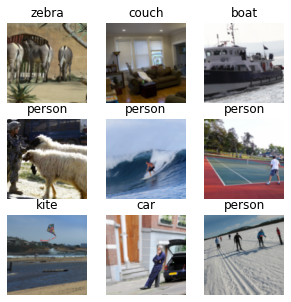

In [ ]:
dls = ImageDataLoaders.from_df(df, bs=64, path=path,
                               fn_col='im', label_col='lbl', valid_col='is_valid',
                               item_tfms=Resize(128),
                               batch_tfms=aug_transforms(size=128))

dls.show_batch(figsize=(5,5))

In [ ]:
learner = cnn_learner(dls, resnet34, metrics=error_rate)
learner.fine_tune(2)
### results:
# .24 error in 3 cycles w/ frac=.5 and sz=224
# .35 error in 2 cycles w/ frac=.2 and sz=128

epoch,train_loss,valid_loss,error_rate,time
0,2.187175,1.754023,0.407369,00:23


epoch,train_loss,valid_loss,error_rate,time
0,1.612157,1.410585,0.365404,00:24
1,1.294265,1.282549,0.350051,00:24


## Interpretation

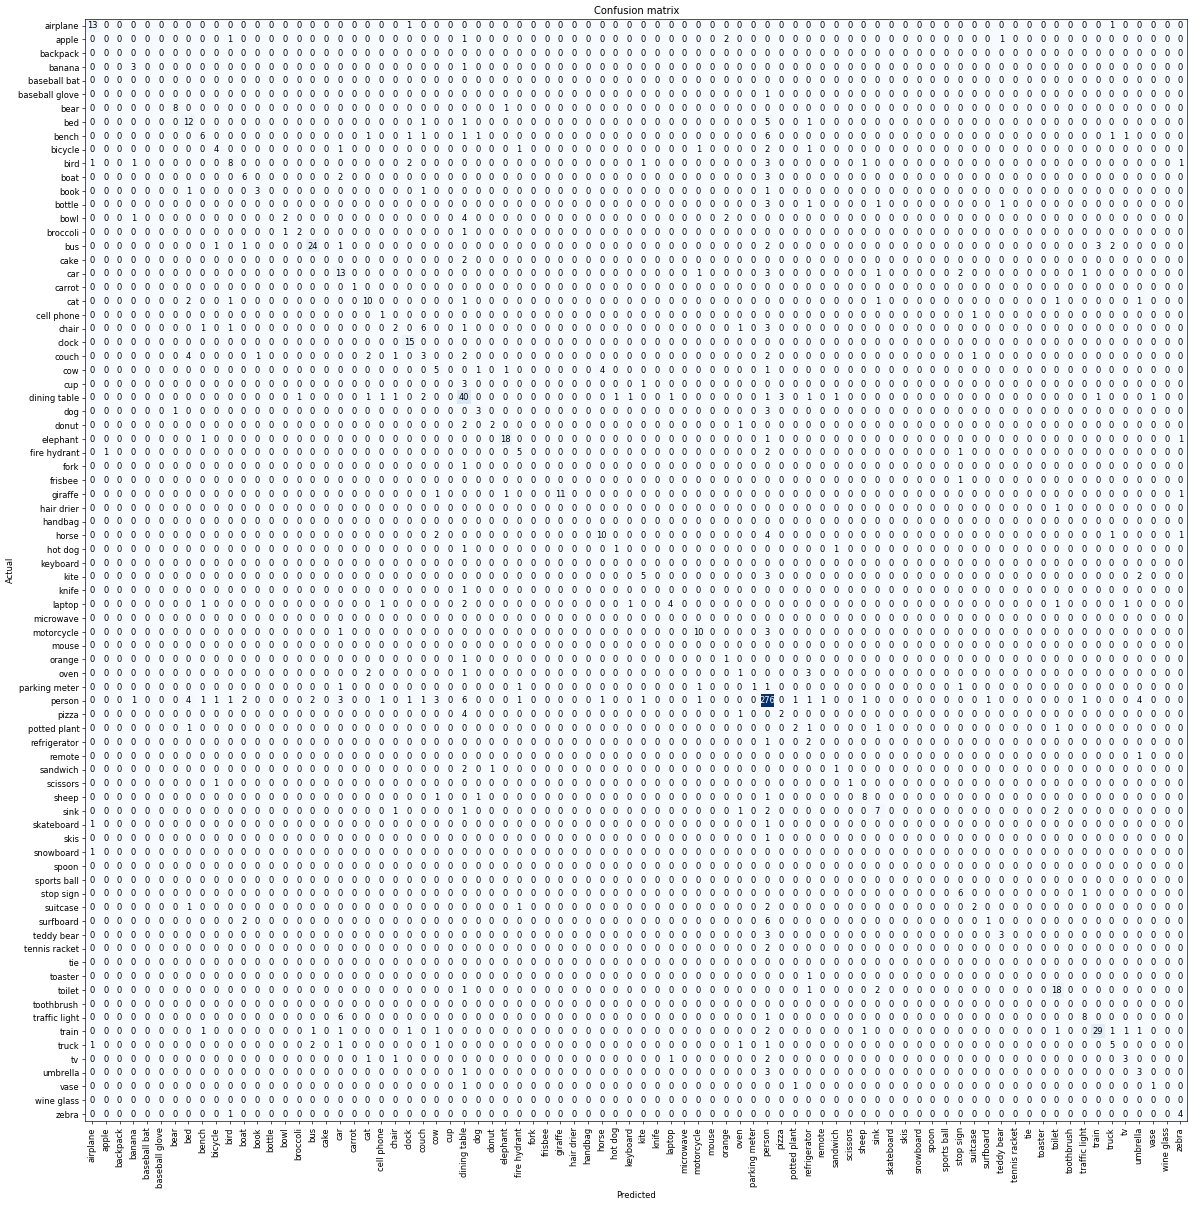

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('bench', 'person', 6),
 ('chair', 'couch', 6),
 ('person', 'dining table', 6),
 ('surfboard', 'person', 6),
 ('traffic light', 'car', 6),
 ('bed', 'person', 5)]

# Draw Largest BBox

## via DataBlock

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    splitter=ColSplitter(),
    get_x=ColReader('im'),
    get_y=ColReader('bbox'),
    item_tfms=[PointScaler(), Resize(224, ResizeMethod.Squish), ToTensor()],
    batch_tfms=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
dls = db.dataloaders(df)
xb,yb = dls.one_batch()
print(xb.shape, yb.shape)
# ib,bb,lb = dls.one_batch()
# print(ib.shape, bb.shape, lb.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64, 2, 2])


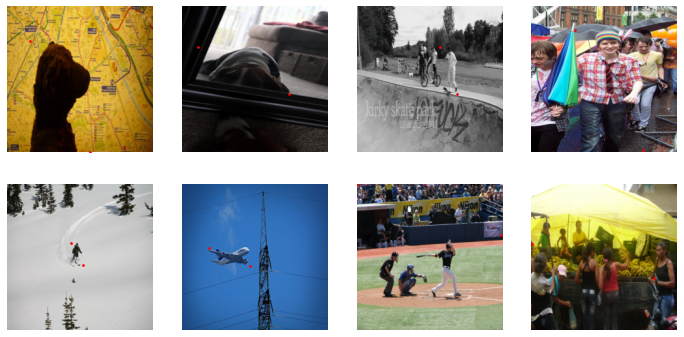

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

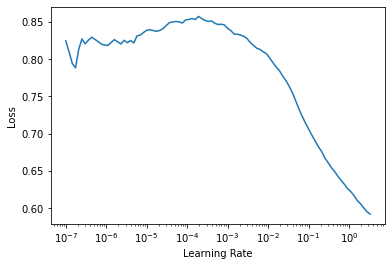

In [ ]:
learner = cnn_learner(dls, resnet18, y_range=(-1,1), batch_size=64)
lr_min,lr_steep = learner.lr_find()

In [ ]:
learner.loss_func

FlattenedLoss of MSELoss()

In [ ]:
lr_min, lr_steep

(0.33113112449646, 0.0831763744354248)

In [ ]:
learner.fine_tune(3, lr=slice(.03,.5)) 

epoch,train_loss,valid_loss,time
0,0.396237,0.178944,00:14


epoch,train_loss,valid_loss,time
0,0.200525,0.138656,00:16
1,0.135152,0.110196,00:16
2,0.109149,0.105884,00:17


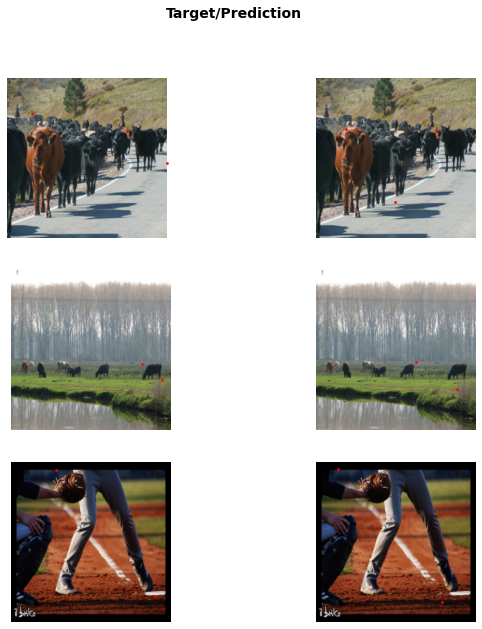

In [ ]:
learner.show_results(nrows=3,ncols=1, figsize=(10,10)) 

## via Transforms

### Showing images and bboxes

#### Grabbing one im and bbox for testing

In [ ]:
paths = L(dfd['im'][i] for i in range(len(dfd['im'])))
path2bbox = {dfd['im'][i]:dfd['bbox'][i] for i in range(len(dfd['im']))}
def get_bbox(p): return path2bbox[p]

imp = paths[random.randint(0,len(paths))]
im = PILImage.create(imp)
bbox = path2bbox[imp]
im.shape, bbox

((480, 640), [190.95, 214.13, 273.86, 479.43])

#### `show_im`, `draw_outline`, `draw_rect`, `draw_text`

https://www.youtube.com/watch?v=Z0ssNAbe81M @ 1:18:00

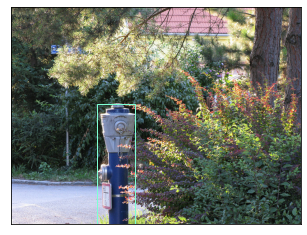

In [ ]:
from matplotlib import patches, patheffects

def show_im(im, figsize=None, ax=None, tickmarks=False):
    if not ax: fig,ax = plt.subplots(figsize=figsize) # we don't care about fig
    ax.imshow(im)
    ax.get_xaxis().set_visible(tickmarks)
    ax.get_yaxis().set_visible(tickmarks)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'),
                        patheffects.Normal()])

def draw_rect(ax, bb, outline=False, color='aquamarine'):
    xy = bb[:2]
    w = bb[2] - bb[0]
    h = bb[3] - bb[1]
    patch = ax.add_patch(patches.Rectangle(xy, w, h, fill=False,
                                           edgecolor=color, lw=1))
    if outline: draw_outline(patch, 3)

def draw_text(ax, xy, txt=None, sz=14, color='aquamarine', outline=True):
    text = ax.text(*xy, txt, verticalalignment='top', color=color,
                   fontsize=sz, weight='bold')
    if outline: draw_outline(text, 1)


ax = show_im(im)
draw_rect(ax, bbox)
draw_text(ax, bbox[:2])

#### `BBox` and `ImageBBox` classes with `show()` methods

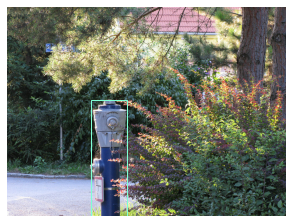

In [ ]:
class BBox(torch.Tensor):
    def show(self, ax=None, **kwargs):
        if not ax: print("Image ax not given.")
        return draw_rect(ax, self, **kwargs)

class ImageBBox(fastuple):
    def show(self, ax=None, **kwargs):
        im, bb = self
        ax = im.show()
        return bb.show(ax=ax, **kwargs)

bbox = BBox(bbox)
imbb = ImageBBox(im, bbox)
imbb.show()

### Building dls with mid level api

A transform for turning an image's path into an ImageBBox.

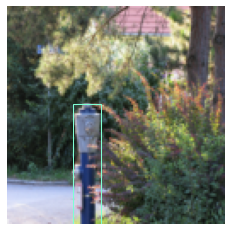

In [ ]:
class ImageBBoxTransform(Transform):
    
    def __init__(self, paths, splits):
        self.train = paths[splits[0]]
        self.valid = paths[splits[1]]
    
    def encodes(self, path):
        im = PILImage.create(path)
        bb = BBox(get_bbox(path))
        return self._resize((im, bb)) # vanilla: ImageBBox(im, bbox)
    
    def _resize(self, imbb, size=128):
        im, bb = imbb
        sizes = torch.true_divide(tensor(im.size*2),size)
        im = Resize(size, ResizeMethod.Squish)(im)
        bb = BBox(torch.true_divide(bb,sizes))
        return ImageBBox(im, bb)

tfm = ImageBBoxTransform(paths, splits)
x = tfm.encodes(imp)
x.show()

In [ ]:
splits = RandomSplitter()(paths)
tfm = ImageBBoxTransform(paths, splits)
tls = TfmdLists(paths, tfm, splits=splits)
dls = tls.dataloaders(after_item=[ToTensor],
                      after_batch=[IntToFloatTensor,
                                   Normalize.from_stats(*imagenet_stats)])

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

### Model

In [ ]:
learner = cnn_learner(dls, arch=resnet34, loss_func=MSELossFlat(), metrics=accuracy)
learner.lr_find()

In [ ]:
learner.fit_one_cycle(4, lr=1e-2)

epoch,train_loss,valid_loss,time
0,2.106742,0.421012,00:18
1,0.558272,0.174619,00:18
2,0.245747,0.140131,00:18
3,0.194730,0.136737,00:18


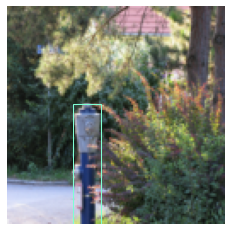

In [ ]:
x = tfm.encodes(imp)
x.show()

In [ ]:
yf = learner.predict(x[0])
yf = BBox(torch.Tensor(yf[0]).flatten()); yf

tensor([ 91.5392, 107.2427, 130.5985, 165.2401])

In [ ]:
x

(PILImage mode=RGB size=128x128,
 tensor([ 38.1900,  57.1013,  54.7720, 127.8480]))

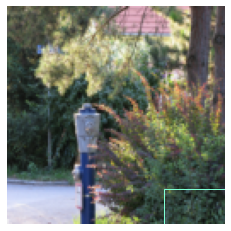

In [ ]:
ImageBBox((x[0], yf)).show();

# Multi-label Classification

In [ ]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               splitter=ColSplitter('is_valid'),
               get_x=ColReader('path'),
               get_y=ColReader('lbls'),
               item_tfms=Resize(128),
               batch_tfms=aug_transforms(size=128))

In [ ]:
dls = db.dataloaders(df)
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 80]))

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.033113110810518265)

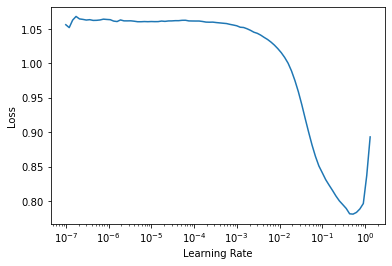

In [ ]:
learner = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.5))
learner.lr_find()

In [ ]:
learner.fine_tune(2, lr=5e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.148594,0.095294,0.970275,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.092035,0.075747,0.974294,00:24
1,0.081918,0.072368,0.975252,00:24


# Largest BBox and Label

In [ ]:
...